In [1]:
# convenience functions and configuration
%matplotlib inline

import sys
import os
from pathlib import Path
from packaging import version
import sklearn
import matplotlib.pyplot as plt
import pandas as pd

# Check Python and library versions
assert sys.version_info >= (3, 7)
# check scikit-learn version
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")


# helper functions to load Excel files.
# Excel CSV-file
def load_csv_pd_data(path, filename, 
                     names=None, 
                     delim_whitespace=False
                    ):
    '''
    load_csv_pd_data() - construct a pandas DataFrame object 
           from data in a Excel CSV file `filename`,
           stored in a folder `path`.
           @names: header-names of columns
    @returns: a pandas DataFrame
    '''
    csv_path = os.path.join(path, filename)
    # DEBUG: print(csv_path)
    return pd.read_csv(csv_path,
                       delim_whitespace=delim_whitespace,
                       names=names,
                      )

# Excel XLS-file
def load_xls_pd_data(path, filename, 
                     names=None
                    ):
    '''
    load_xls_pd_data() - construct a pandas DataFrame object 
           from data in a Excel xls-file `filename`,
           stored in a folder `path`.
    @returns: a pandas DataFrame
    '''
    xls_path = os.path.join(path, filename)
    # DEBUG: print(xls_path)
    return pd.read_excel(xls_path,
                         names=names
                        )


# Increase font size for plots
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)


# Create the `images/training_linear_models` folder
IMAGES_PATH = Path() / "images" / "clustering"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

---
### DBSCAN clustering

**DBSCAN** is een acroniem dat staat voor *Density-BaSed Clustering of Applications with Noise*, dat wil zeggen 'op dichtheid gebaseerde ruimtelijke clustering van toepassingen met ruis'. 

Dit is een belachelijk lange naam voor wat in wezen een heel eenvoudige techniek is:
1. Selecteer een willekeurige `point` coördinaat uit een gegevenslijst.
2. Verkrijg alle buren met een `epsilon` afstand vanaf `point`.
3. Als er minder dan `min_points` buren worden ontdekt, herhaal dan stap 1 met een ander willekeurig `point`. Anders groepeer je `point` en zijn buren in een enkele cluster.
4. Herhaal stap 2 en 3 voor alle nieuw ontdekte buren. Alle aangrenzende dichte punten worden samengevoegd in het cluster. Iteraties eindigen nadat het cluster stopt met uitbreiden.
5. Herhaal na het uitpakken van het hele cluster stap 1-4 op alle datapunten waarvan de *density* nog niet is geanalyseerd.

Laten we even kijken naar de dataset uit het K-Means voorbeeld...

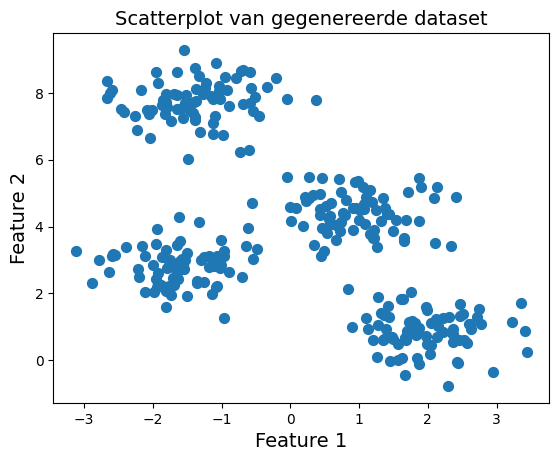

In [2]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Maak een dataset met 300 punten, gegroepeerd rond 4 clusters
X, y = make_blobs(n_samples=300, centers=4, random_state=0, cluster_std=0.60)

# Plot de dataset
plt.scatter(X[:, 0], X[:, 1], s=50)
plt.title("Scatterplot van gegenereerde dataset")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


Wat gebeurt er als we dit nu uitvoeren met DBSCAN?

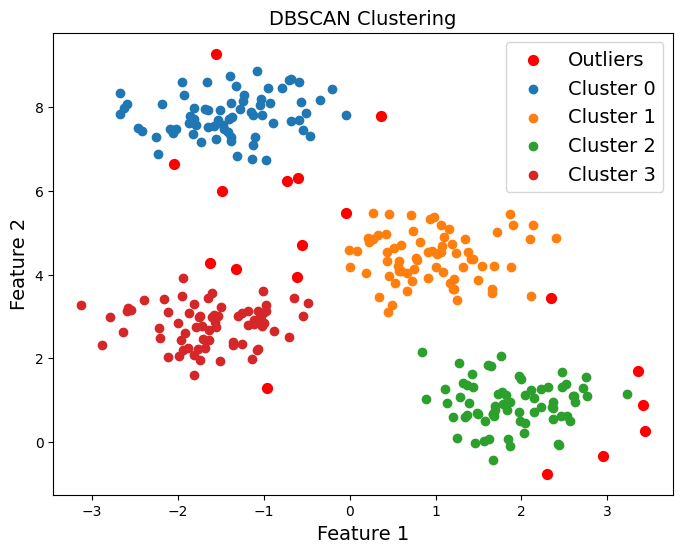

In [3]:
# DBSCAN model instellen
dbscan = DBSCAN(eps=0.5, min_samples=5)

# DBSCAN toepassen op de dataset
dbscan_labels = dbscan.fit_predict(X)

# Plot de clusters en markeer outliers
plt.figure(figsize=(8, 6))
unique_labels = np.unique(dbscan_labels)
for label in unique_labels:
    if label == -1:
        # Outliers (label = -1)
        plt.scatter(X[dbscan_labels == label, 0], X[dbscan_labels == label, 1], 
                    color='red', s=50, label='Outliers')
    else:
        # Clusters
        plt.scatter(X[dbscan_labels == label, 0], X[dbscan_labels == label, 1], 
                    label=f'Cluster {label}')

plt.title("DBSCAN Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

---

## Density clustering DBSCAN

Ander voorbeeld ....

Stel dat een astronoom een nieuwe planeet ontdekt aan de verafgelegen rand van het zonnestelsel. De planeet heeft, net als Staturnus, meerdere ringen die in constante banen rond het middelpunt draaien. Elke ring is gevormd uit duizenden stenen. We zullen deze rotsen modelleren als individuele punten gedefinieerd door x- en y-coördinaten. 

Kunnen we deze ringen vinden met clustering techieken, zoals k-Mean?

Laten we drie rotsringen genereren die zijn samengesteld uit veel stenen, met behulp van de `make_circles` functie van scikit-learn.

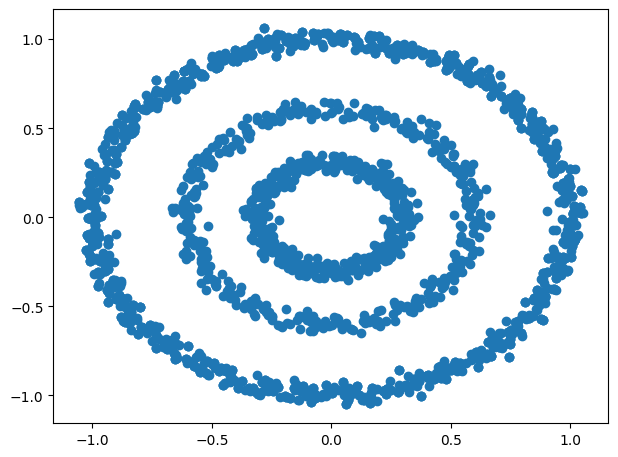

In [4]:
# simulating rings round a planet
from sklearn.datasets import make_circles

x_coordinates = []
y_coordinates = []
for factor in [.3, .6, .99]:
    rock_ring, _ = make_circles(
        n_samples=800,
        factor=factor,
        noise=0.03,random_state=1
    )
    for rock in rock_ring:
        x_coordinates.append(rock[0])
        y_coordinates.append(rock[1])

plt.scatter(x_coordinates, y_coordinates)
# optional: save plot
save_fig("rock_rings")
plt.show()

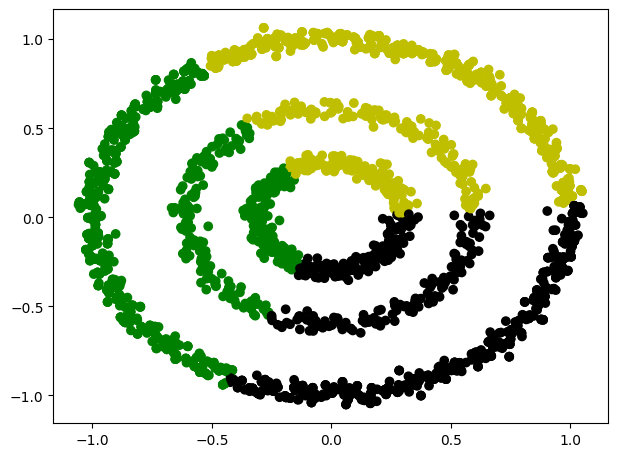

In [5]:
# search for these 3 clusters using k_Means by setting K to 3
from sklearn.cluster import KMeans

rocks = [
    [x_coordinates[i], y_coordinates[i]] for i in range(len(x_coordinates))
]

# get the calculated clusters
rock_clusters = KMeans(3).fit_predict(rocks)

# define colors for the clusters
colors = [
    ['g', 'y', 'k'][cluster] for cluster in rock_clusters
]
# plot
plt.scatter(x_coordinates, y_coordinates, color=colors)
# optional: save plot
save_fig("rock_rings-kmeans_failure_k3")
plt.show()

Zo je ziet is het resultaat een complete mislukking!

K-Means ontleedt de gegevens in drie symmetrische segmenten, en elk segment overspant meerdere ringen. Wat ging er mis?

Welnu, k-Means nam aan dat de drie clusters werden gedefinieerd door drie unieke centra, maar de werkelijke ringen draaien rond een enkel centraal punt. Het verschil tussen clusters wordt niet bepaald door centraliteit, maar door dichtheid! Elke ring is opgebouwd uit een dichte verzameling punten, met lege gebieden van dunbevolkte ruimte die als grenzen tussen ringen dienen.

#### Opdracht DBSCAN clustering

Gebruik `DBSCAN` uit scikit-learn om de clustering van de rotsringen te vinden.

Maak met clustermodel DBSCAN een dichtheidsclustering model van de rotsringen. Een `epsilon`waarde van 0.1 wordt doorgegeven met behulp van de `eps`parameter. Een `min_points`waarde van 10 wordt doorgegeven met behulp van de parameter `min_samples`.

Tip: maak gebruik van de [Scikit-learn documentatie](https://scikit-learn.org/stable/https://scikit-learn.org/stable/)

Het resultaat is weergegeven in het volgende plaatje:
![DBSCAN_clustering](./images/rock_rings-DBSCAN_clustering.png)

Ofwel, DBSCAN heeft met succes de drie rotsringen geïdentificeerd. Het algoritme slaagde waar k-Means faalde.

In [6]:
# hier komt jouw code...
